# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Linear-Regression"><b>Analysis</b> - Linear-Regression</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
import numpy
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        pr_auc = auc(recall, precision)
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    return highestscore[1], acc, highestscore[0], highestscore[5]
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        yhat = model.predict(x_test) 
        pr_auc = auc(recall, precision)
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    return highestscore[1], acc, highestscore[0], highestscore[5]
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        yhat = model.predict(x_test) 
        pr_auc = auc(recall, precision)
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    return highestscore[1], acc, highestscore[0], highestscore[5]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    plt.title(f"Precision vs. Recall Threshold Chart for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1 - PRC-AUC score: {round(auc(recall1[ix1:], precision1[ix1:]), 2)}")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2 - PRC-AUC score: {round(auc(recall2[ix2:], precision2[ix2:]), 2)}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc="upper right")
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2]
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Linear Regression

In [3]:
# Make sure the data is from all dates
df = pd.read_csv("../Neo4j_output/Centrality_Output.csv")
# Replace NaN with 0 to include developers who did not introduce any bugs
df['Number_of_Bugs'] = df['Number_of_Bugs'].fillna(0)
print(df)

                    Name   PageRank    Betweenness  Closeness  Harmonic  \
0             Seth Vargo  24.098295  172342.464826   0.917656  0.955134   
1     Mitchell Hashimoto  24.093374  263957.868091   0.879363  0.931406   
2          Chris Roberts  21.082051  177846.949345   0.842297  0.906385   
3               tfanning  19.974389   59072.500908   0.847842  0.910267   
4             Brian Cain  19.631400  131598.446530   0.818503  0.889129   
...                  ...        ...            ...        ...       ...   
1155               winky   0.153670       0.000000   0.487179  0.492091   
1156           Yufan Lou   0.153324       0.000000   0.459010  0.471096   
1157       Aidan Feldman   0.152928       0.000000   0.488000  0.492954   
1158        Steven Leung   0.152204       0.000000   0.498066  0.499569   
1159             Murathe   0.150903       0.000000   0.487795  0.492522   

        Degree  Number_of_Bugs  
0     108731.0           233.0  
1     786949.0           865.0  


#### Predictions with sklearn

In [4]:
linear_regressor = LinearRegression()

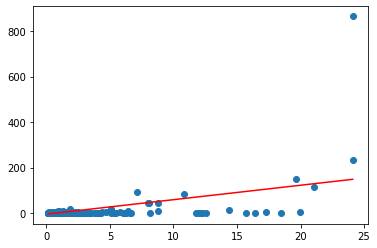

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     380.9
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           1.47e-73
Time:                        14:42:32   Log-Likelihood:                -5312.7
No. Observations:                1160   AIC:                         1.063e+04
Df Residuals:                    1158   BIC:                         1.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4607      0.761     -5.859      0.0

In [5]:
x = df['PageRank'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [6]:
regression_results(y, y_pred)

explained_variance:  0.2475
r2:  0.2475
MAE:  4.8982
MSE:  556.645
RMSE:  23.5933


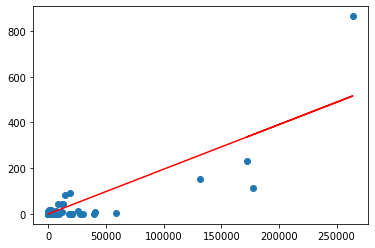

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     2846.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):          3.09e-314
Time:                        14:42:32   Log-Likelihood:                -4758.1
No. Observations:                1160   AIC:                             9520.
Df Residuals:                    1158   BIC:                             9530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4835      0.432     -1.120      0.2

In [7]:
x = df['Betweenness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [8]:
regression_results(y, y_pred)

explained_variance:  0.7108
r2:  0.7108
MAE:  2.1069
MSE:  213.94
RMSE:  14.6267


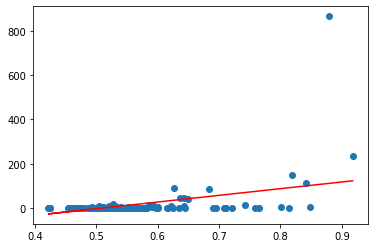

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     274.3
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           1.84e-55
Time:                        14:42:32   Log-Likelihood:                -5354.3
No. Observations:                1160   AIC:                         1.071e+04
Df Residuals:                    1158   BIC:                         1.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -153.1468      9.375    -16.335      0.0

In [9]:
x = df['Closeness'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [10]:
regression_results(y, y_pred)

explained_variance:  0.1915
r2:  0.1915
MAE:  5.8539
MSE:  598.0523
RMSE:  24.4551


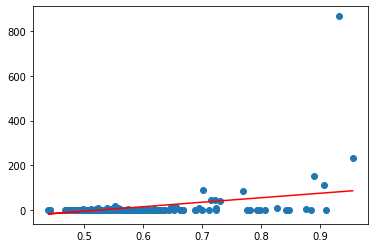

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     196.1
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           2.85e-41
Time:                        14:42:33   Log-Likelihood:                -5386.9
No. Observations:                1160   AIC:                         1.078e+04
Df Residuals:                    1158   BIC:                         1.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -104.1860      7.597    -13.715      0.0

In [11]:
x = df['Harmonic'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [12]:
regression_results(y, y_pred)

explained_variance:  0.1448
r2:  0.1448
MAE:  5.983
MSE:  632.6194
RMSE:  25.1519


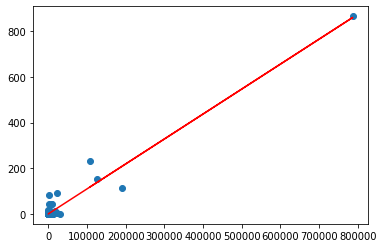

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 2.266e+04
Date:                Tue, 01 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:42:33   Log-Likelihood:                -3724.0
No. Observations:                1160   AIC:                             7452.
Df Residuals:                    1158   BIC:                             7462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1904      0.177      1.078      0.2

In [13]:
x = df['Degree'].values.reshape(-1, 1)
y = df['Number_of_Bugs'].values.reshape(-1, 1)
model = linear_regressor.fit(x, y)
y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

In [14]:
regression_results(y, y_pred)

explained_variance:  0.9514
r2:  0.9514
MAE:  1.0246
MSE:  35.9721
RMSE:  5.9977


In [15]:
x = df[['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']]
y = df['Number_of_Bugs']
#model = linear_regressor.fit(x, y)
#y_pred = plot_prediction(model, x, y)

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions = model.predict(x)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:         Number_of_Bugs   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     4607.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:42:33   Log-Likelihood:                -3712.9
No. Observations:                1160   AIC:                             7438.
Df Residuals:                    1154   BIC:                             7468.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -9.3917      7.621     -1.232      

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [16]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders
graph_df = pd.read_csv("../Neo4j_output/Developer_Folder_Output.csv")

new_columns = {}

# Generate binary classification for our dataframe based on if a developer 
# introduced a bug or not with the corresponding commit
for index in graph_df.index:
    if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
        graph_df.loc[index, "Bug"] = 0
    else:
        graph_df.loc[index, "Bug"] = 1
        
    # separate each node2vec embedding into it's own unique label
    embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
    for i, embedding in enumerate(embeddings):
        if f"emb_{i}" not in new_columns:
            new_columns[f"emb_{i}"] = []
            new_columns[f"emb_{i}"].append(embedding)
        else:
            new_columns[f"emb_{i}"].append(embedding)

# delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
del graph_df['n2vEmbedding']
temp_df = pd.DataFrame.from_dict(new_columns)
graph_df = graph_df.join(temp_df)
            
x = graph_df["Name"]
y = graph_df["Bug"]

In [17]:
graph_df

,Name,Folder,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,emb_0,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,Jeff Escalante,website/source,0,5.282073,8513.180806,0.572628,0.626833,10263.0,40,0.263461,...,-0.535386,0.030957,0.108155,0.085016,0.213371,0.330279,0.234479,-0.142362,0.172831,-0.102320
1,Jeff Escalante,website,0,5.282073,8513.180806,0.572628,0.626833,10263.0,40,0.263461,...,-0.535386,0.030957,0.108155,0.085016,0.213371,0.330279,0.234479,-0.142362,0.172831,-0.102320
2,Jeff Escalante,website,0,5.282073,8513.180806,0.572628,0.626833,10263.0,40,0.263461,...,-0.535386,0.030957,0.108155,0.085016,0.213371,0.330279,0.234479,-0.142362,0.172831,-0.102320
3,Jeff Escalante,website/source/layouts,0,5.282073,8513.180806,0.572628,0.626833,10263.0,40,0.263461,...,-0.535386,0.030957,0.108155,0.085016,0.213371,0.330279,0.234479,-0.142362,0.172831,-0.102320
4,Jeff Escalante,website/source/assets/javascripts,0,5.282073,8513.180806,0.572628,0.626833,10263.0,40,0.263461,...,-0.535386,0.030957,0.108155,0.085016,0.213371,0.330279,0.234479,-0.142362,0.172831,-0.102320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42085,Ilkka Laukkanen,RootDir,0,1.523850,128.517498,0.531408,0.559103,409.0,90,-0.018145,...,-0.144863,0.273971,0.126610,0.236097,0.261767,0.047874,-0.101311,-0.233997,0.215839,0.008707
42086,Ilkka Laukkanen,RootDir,0,1.523850,128.517498,0.531408,0.559103,409.0,90,-0.018145,...,-0.144863,0.273971,0.126610,0.236097,0.261767,0.047874,-0.101311,-0.233997,0.215839,0.008707
42087,Jonathan Rudenberg,test/vagrant,0,1.266816,26.999466,0.530435,0.557377,157.0,99,-0.323451,...,0.070738,-0.016437,0.276776,-0.101360,0.126255,0.006769,-0.151035,-0.125658,0.085403,0.018604
42088,Jonathan Rudenberg,lib,0,1.266816,26.999466,0.530435,0.557377,157.0,99,-0.323451,...,0.070738,-0.016437,0.276776,-0.101360,0.126255,0.006769,-0.151035,-0.125658,0.085403,0.018604


Print out the class counts for our binary classification. In this case, our results are 40,143 <b>False (0)</b> counts, and 1,947 <b>True (1)</b> counts.

In [18]:
print(graph_df['Bug'].value_counts())
# 2D Array containing all results
results_data = [[None for j in range(9)] for i in range(64)]

0    40143
1     1947
Name: Bug, dtype: int64


Creating models...

In [19]:
lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
rf_model1 = RandomForestClassifier(n_estimators=120)
rf_model2 = RandomForestClassifier(n_estimators=120)
xgb_model1 = XGBClassifier(verbosity = 0)
xgb_model2 = XGBClassifier(verbosity = 0)

In [20]:
'''
train_test_split params
-----------------------
graph_df: Graph dataset
test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
random_state = used to create reproducible, or deterministic results.
'''
train, test = train_test_split(graph_df, test_size=0.3, random_state = 5)
train = train.reset_index()
test = test.reset_index()

# Labels used for model 1
labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

# Labels used for model 2
labels2 = set(list(graph_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'Folder', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

Print out the class counts for our binary classification in the training dataset. In this case, our results are 28,083 <b>False (0)</b> counts, and 1,380 <b>True (1)</b> counts.

In [21]:
print(train['Bug'].value_counts())
train

0    28083
1     1380
Name: Bug, dtype: int64


,index,Name,Folder,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,5767,Chris Roberts,lib/vagrant/action,0,21.082051,177846.949345,0.842297,0.906385,190286.0,40,...,-0.086840,0.063502,0.212061,-0.063723,0.091614,0.111133,0.034208,0.243075,0.069278,0.054462
1,3206,Chris Roberts,lib/vagrant,0,21.082051,177846.949345,0.842297,0.906385,190286.0,40,...,-0.086840,0.063502,0.212061,-0.063723,0.091614,0.111133,0.034208,0.243075,0.069278,0.054462
2,31523,Seth Vargo,plugins/pushes/atlas,0,24.098295,172342.464826,0.917656,0.955134,108731.0,62,...,-0.132192,0.108444,0.209426,-0.036023,0.065235,0.131047,-0.004569,0.001202,0.244801,-0.079068
3,20609,Mitchell Hashimoto,lib,0,24.093374,263957.868091,0.879363,0.931406,786949.0,62,...,-0.113836,0.114613,0.279377,0.071080,0.063264,0.053219,-0.159938,-0.008980,0.059132,-0.167552
4,4194,Chris Roberts,test/unit/plugins/hosts/windows/cap,0,21.082051,177846.949345,0.842297,0.906385,190286.0,40,...,-0.086840,0.063502,0.212061,-0.063723,0.091614,0.111133,0.034208,0.243075,0.069278,0.054462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29458,5520,Chris Roberts,plugins/provisioners/shell,0,21.082051,177846.949345,0.842297,0.906385,190286.0,40,...,-0.086840,0.063502,0.212061,-0.063723,0.091614,0.111133,0.034208,0.243075,0.069278,0.054462
29459,35814,tfanning,website/source/vmware,0,19.974389,59072.500908,0.847842,0.910267,11936.0,62,...,-0.170262,0.000709,0.219289,-0.100205,0.096132,0.146887,-0.115144,0.080678,-0.044150,0.075182
29460,20463,Mitchell Hashimoto,plugins/commands/destroy,0,24.093374,263957.868091,0.879363,0.931406,786949.0,62,...,-0.113836,0.114613,0.279377,0.071080,0.063264,0.053219,-0.159938,-0.008980,0.059132,-0.167552
29461,18638,Mitchell Hashimoto,lib/vagrant/command,0,24.093374,263957.868091,0.879363,0.931406,786949.0,62,...,-0.113836,0.114613,0.279377,0.071080,0.063264,0.053219,-0.159938,-0.008980,0.059132,-0.167552


Print out the class counts for our binary classification in the training dataset. In this case, our results are 12,060 <b>False (0)</b> counts, and 567 <b>True (1)</b> counts.

In [22]:
print(test['Bug'].value_counts())
test

0    12060
1      567
Name: Bug, dtype: int64


,index,Name,Folder,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,28295,Mitchell Hashimoto,website/docs/source/v2/provisioning,0,24.093374,263957.868091,0.879363,0.931406,786949.0,62,...,-0.113836,0.114613,0.279377,0.071080,0.063264,0.053219,-0.159938,-0.008980,0.059132,-0.167552
1,10680,Brian Cain,plugins/providers/hyperv/scripts,0,19.631400,131598.446530,0.818503,0.889129,125936.0,40,...,-0.214533,0.171765,0.191422,-0.140302,0.010645,0.141635,0.036593,0.140475,0.063748,-0.006345
2,34733,Seth Vargo,templates/locales,0,24.098295,172342.464826,0.917656,0.955134,108731.0,62,...,-0.132192,0.108444,0.209426,-0.036023,0.065235,0.131047,-0.004569,0.001202,0.244801,-0.079068
3,18125,Mitchell Hashimoto,test/{unit => unit_legacy}/vagrant/command,0,24.093374,263957.868091,0.879363,0.931406,786949.0,62,...,-0.113836,0.114613,0.279377,0.071080,0.063264,0.053219,-0.159938,-0.008980,0.059132,-0.167552
4,9623,Brian Cain,website/source/intro/getting-started,0,19.631400,131598.446530,0.818503,0.889129,125936.0,40,...,-0.214533,0.171765,0.191422,-0.140302,0.010645,0.141635,0.036593,0.140475,0.063748,-0.006345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12622,22769,Mitchell Hashimoto,plugins/provisioners/ansible,0,24.093374,263957.868091,0.879363,0.931406,786949.0,62,...,-0.113836,0.114613,0.279377,0.071080,0.063264,0.053219,-0.159938,-0.008980,0.059132,-0.167552
12623,29776,Mitchell Hashimoto,plugins/guests/linux,1,24.093374,263957.868091,0.879363,0.931406,786949.0,62,...,-0.113836,0.114613,0.279377,0.071080,0.063264,0.053219,-0.159938,-0.008980,0.059132,-0.167552
12624,9824,Brian Cain,lib/vagrant/action/builtin,0,19.631400,131598.446530,0.818503,0.889129,125936.0,40,...,-0.214533,0.171765,0.191422,-0.140302,0.010645,0.141635,0.036593,0.140475,0.063748,-0.006345
12625,3901,Chris Roberts,plugins/synced_folders/smb,0,21.082051,177846.949345,0.842297,0.906385,190286.0,40,...,-0.086840,0.063502,0.212061,-0.063723,0.091614,0.111133,0.034208,0.243075,0.069278,0.054462


In [23]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[0][0] = "Original_Logistic_Regression"
results_data[0][1] = lr_model1.score(x1_test, y_test)
results_data[0][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[1][0] = "Original_Random_Forrest"
results_data[1][1] = rf_model1.score(x1_test, y_test)
results_data[1][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[2][0] = "Original_XGB_Classifier"
results_data[2][1] = xgb_model1.score(x1_test, y_test)
results_data[2][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.9123307198859587
Logistic regression training score for model 2: 0.9560465668804942
Random Forrest Classification training score for model 1: 0.9588184050051477
Random Forrest Classification training score for model 2: 0.9593727726300784
XGB Classifier training score for model 1: 0.9587392096301576
XGB Classifier training score for model 2: 0.9593727726300784


Compare model scores for Logistic Regression

In [24]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[0][3] = acc1
results_data[0][4] = acc2
results_data[0][5] = prc_val1
results_data[0][6] = prc_val2
results_data[0][7] = pr_auc1
results_data[0][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[1][3] = acc1
results_data[1][4] = acc2
results_data[1][5] = prc_val1
results_data[1][6] = prc_val2
results_data[1][7] = pr_auc1
results_data[1][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[2][3] = acc1
results_data[2][4] = acc2
results_data[2][5] = prc_val1
results_data[2][6] = prc_val2
results_data[2][7] = pr_auc1
results_data[2][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5004385772489698
Average Precision-Recall Score: 0.050087054027082106
PRC-AUC for model 1: 0.04766299826119086
Accuracy: 0.912
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     12060
           1       0.06      0.07      0.06       567

    accuracy                           0.91     12627
   macro avg       0.51      0.51      0.51     12627
weighted avg       0.92      0.91      0.91     12627


Scores for model 2
------------------
Roc_Auc Score: 0.6914609053497941
Average Precision-Recall Score: 0.14212150089730613
PRC-AUC for model 2: 0.14678783727732067
Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     12060
           1       0.62      0.05      0.10       567

    accuracy 

###### Compare Precision-Recall thresholds between models

TODO: Get it to work with randomforrest and XGBoost

Best Threshold=0.381792, F1-Score=0.097 for model 1
Best Threshold=0.141344, F1-Score=0.203 for model 2


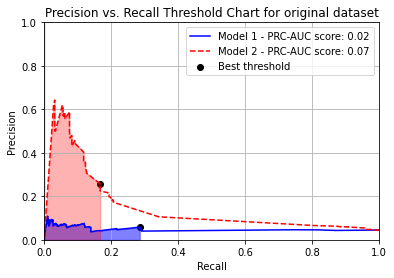

In [25]:
best_threshold1, best_threshold2 = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset")

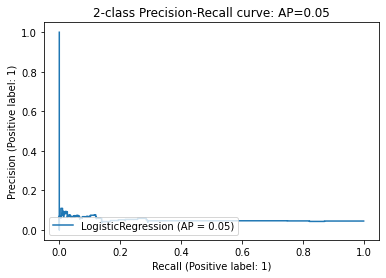

In [26]:
simple_threshold_plot(lr_model1, x1_test, y_test)

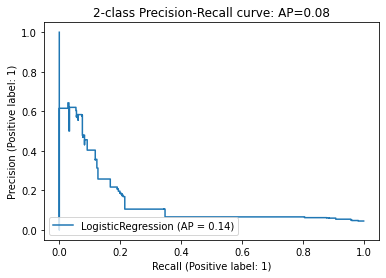

In [27]:
simple_threshold_plot(lr_model2, x2_test, y_test)

Using the best thresholds...

In [28]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
results_data[3][1] = lr_model1.score(x1_test, y_test)
results_data[3][2] = lr_model2.score(x2_test, y_test)
results_data[3][3] = acc1
results_data[3][4] = acc2
results_data[3][5] = prc_val1
results_data[3][6] = prc_val2
results_data[3][7] = pr_auc1
results_data[3][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5004385772489698
Average Precision-Recall Score: 0.050087054027082106
PRC-AUC for model 1: 0.016463093787050496
Accuracy: 0.762
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     12060
           1       0.06      0.29      0.10       567

    accuracy                           0.76     12627
   macro avg       0.51      0.54      0.48     12627
weighted avg       0.92      0.76      0.83     12627


Scores for model 2
------------------
Roc_Auc Score: 0.6914609053497941
Average Precision-Recall Score: 0.14212150089730613
PRC-AUC for model 2: 0.06875628380320373
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12060
           1       0.26      0.17      0.20       567

    accuracy                           0.94     12627
   macro avg       0.61      0.57      0.59     12627
wei

### Cross Validation

In [29]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df['Bug']

In [30]:
print("Cross validation results for model 1")
print("------------------------------------")

cv_results = cross_validate(lr_model1, x1, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

print("\nCross validation results for model 2")
print("------------------------------------")

cv_results = cross_validate(lr_model2, x2, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

Cross validation results for model 1
------------------------------------
[0.91952958 0.95374198 0.86272274]

Cross validation results for model 2
------------------------------------
[0.95203136 0.95374198 0.94903778]


#### Model 1 Cross Validation

#### Leave One Out

In [31]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model1, x1, y)

#### Repeated KFold

In [32]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, x1, y)
results_data[4][0] = "Original_Logistic_Regression_rkf"
results_data[4][1] = model_score
results_data[4][3] = acc
results_data[4][5] = prc_val
results_data[4][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, x1, y, best_threshold1)
results_data[5][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
results_data[5][1] = model_score
results_data[5][3] = acc
results_data[5][5] = prc_val
results_data[5][7] = pr_auc

Rkf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model1, x1, y)
results_data[6][0] = "Original_Random_Forrest_rkf"
results_data[6][1] = model_score
results_data[6][3] = acc
results_data[6][5] = prc_val
results_data[6][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model1, x1, y)
results_data[7][0] = "Original_XGB_Classifier_rkf"
results_data[7][1] = model_score
results_data[7][3] = acc
results_data[7][5] = prc_val
results_data[7][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 42087 42088 42089] | TEST: [    7     9    16 ... 42055 42079 42082]

Model Score: 0.9154193395105725
Average Precision-Recall Score: 0.05521033194717617
PRC-AUC Score: 0.05735636075204099
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3997
           1       0.10      0.09      0.10       212

    accuracy                           0.92      4209
   macro avg       0.53      0.52      0.53      4209
weighted avg       0.91      0.92      0.91      4209

Accuracy: 0.915
---------------------
With best threshold
TRAIN: [    0     1     4 ... 42087 42088 42089] | TEST: [    2     3     9 ... 42057 42067 42084]

Model Score: 0.910192444761226
Average Precision-Recall Score: 0.05320161865307957
PRC-AUC Score: 0.1691576909774305
Classification Report:

          

#### Stratified KFold

In [33]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, x1, y)
results_data[8][0] = "Original_Logistic_Regression_skf"
results_data[8][1] = model_score
results_data[8][3] = acc
results_data[8][5] = prc_val
results_data[8][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, x1, y, best_threshold1)
results_data[9][0] = "Original_Logistic_Regression_skf_Best_Threshold"
results_data[9][1] = model_score
results_data[9][3] = acc
results_data[9][5] = prc_val
results_data[9][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model1, x1, y)
results_data[10][0] = "Original_Random_Forrest_skf"
results_data[10][1] = model_score
results_data[10][3] = acc
results_data[10][5] = prc_val
results_data[10][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model1, x1, y)
results_data[11][0] = "Original_XGB_Classifier_skf"
results_data[11][1] = model_score
results_data[11][3] = acc
results_data[11][5] = prc_val
results_data[11][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 42087 42088 42089] | TEST: [33414 33415 33416 ... 40168 40169 40170]

Model Score: 0.8823948681397007

Average Precision-Recall Score: 0.0630821745881312
PRC-AUC Score: 0.1324291135716762
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      4014
           1       0.12      0.24      0.16       195

    accuracy                           0.88      4209
   macro avg       0.54      0.57      0.55      4209
weighted avg       0.92      0.88      0.90      4209

Accuracy: 0.882
---------------------
With best threshold
TRAIN: [    0     1     2 ... 42087 42088 42089] | TEST: [33414 33415 33416 ... 40168 40169 40170]

Model Score: 0.8823948681397007

Average Precision-Recall Score: 0.0630821745881312
PRC-AUC Score: 0.5419229775630751
Classification Report:

          

#### Time Series Split

In [34]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, x1, y)
results_data[12][0] = "Original_Logistic_Regression_tss"
results_data[12][1] = model_score
results_data[12][3] = acc
results_data[12][5] = prc_val
results_data[12][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, x1, y, best_threshold1)
results_data[13][0] = "Original_Logistic_Regression_tss_Best_Threshold"
results_data[13][1] = model_score
results_data[13][3] = acc
results_data[13][5] = prc_val
results_data[13][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(rf_model1, x1, y)
results_data[14][0] = "Original_Random_Forrest_tss"
results_data[14][1] = model_score
results_data[14][3] = acc
results_data[14][5] = prc_val
results_data[14][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model1, x1, y)
results_data[15][0] = "Original_XGB_Classifier_tss"
results_data[15][1] = model_score
results_data[15][3] = acc
results_data[15][5] = prc_val
results_data[15][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 28057 28058 28059] | TEST: [28060 28061 28062 ... 35072 35073 35074]

Model Score: 0.2551674982181041

Average Precision-Recall Score: 0.1392190062428205
PRC-AUC Score: 0.193526642008781
Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.26      0.37      5860
           1       0.06      0.25      0.10      1155

    accuracy                           0.26      7015
   macro avg       0.35      0.25      0.23      7015
weighted avg       0.54      0.26      0.32      7015

Accuracy: 0.255
---------------------
With best threshold
TRAIN: [    0     1     2 ... 28057 28058 28059] | TEST: [28060 28061 28062 ... 35072 35073 35074]

Model Score: 0.2551674982181041

Average Precision-Recall Score: 0.1392190062428205
PRC-AUC Score: 0.21586785133042052
Classification Report:

          

#### Model 2 Cross Validation

#### Leave One Out

In [35]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model2, x2, y)

#### Repeated KFold

In [36]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, x2, y)
results_data[4][2] = model_score
results_data[4][4] = acc
results_data[4][6] = prc_val
results_data[4][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, x2, y, best_threshold2)
results_data[5][2] = model_score
results_data[5][4] = acc
results_data[5][6] = prc_val
results_data[5][8] = pr_auc

Rkf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model2, x2, y)
results_data[6][2] = model_score
results_data[6][4] = acc
results_data[6][6] = prc_val
results_data[6][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model2, x2, y)
results_data[7][2] = model_score
results_data[7][4] = acc
results_data[7][6] = prc_val
results_data[7][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 42087 42088 42089] | TEST: [    6    10    32 ... 42063 42084 42086]

Model Score: 0.957472083630316
Average Precision-Recall Score: 0.09983020068551074
PRC-AUC Score: 0.17948497963713494
Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4022
           1       0.65      0.09      0.16       187

    accuracy                           0.96      4209
   macro avg       0.81      0.54      0.57      4209
weighted avg       0.95      0.96      0.94      4209

Accuracy: 0.957
---------------------
With best threshold
TRAIN: [    0     1     2 ... 42087 42088 42089] | TEST: [    7     9    16 ... 42055 42079 42082]

Model Score: 0.9515324305060584
Average Precision-Recall Score: 0.10450873982457248
PRC-AUC Score: 0.3132122799268
Classification Report:

             

#### Stratified KFold

In [37]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, x2, y)
results_data[8][2] = model_score
results_data[8][4] = acc
results_data[8][6] = prc_val
results_data[8][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, x2, y, best_threshold2)
results_data[9][2] = model_score
results_data[9][4] = acc
results_data[9][6] = prc_val
results_data[9][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model2, x2, y)
results_data[10][2] = model_score
results_data[10][4] = acc
results_data[10][6] = prc_val
results_data[10][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model2, x2, y)
results_data[11][2] = model_score
results_data[11][4] = acc
results_data[11][6] = prc_val
results_data[11][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 42087 42088 42089] | TEST: [12410 12411 12412 ... 29550 29551 29552]

Model Score: 0.9505820860061772

Average Precision-Recall Score: 0.04632929436920884
PRC-AUC Score: 0.025854229962583818
Classification Report:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4014
           1       0.00      0.00      0.00       195

    accuracy                           0.95      4209
   macro avg       0.48      0.50      0.49      4209
weighted avg       0.91      0.95      0.93      4209

Accuracy: 0.951
---------------------
With best threshold
TRAIN: [    0     1     2 ... 42087 42088 42089] | TEST: [12410 12411 12412 ... 29550 29551 29552]

Model Score: 0.9505820860061772

Average Precision-Recall Score: 0.04632929436920884
PRC-AUC Score: 0.02316464718460442
Classification Report:

     

#### Time Series Split

In [38]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, x2, y)
results_data[12][2] = model_score
results_data[12][4] = acc
results_data[12][6] = prc_val
results_data[12][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, x2, y, best_threshold2)
results_data[13][2] = model_score
results_data[13][4] = acc
results_data[13][6] = prc_val
results_data[13][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(rf_model2, x2, y)
results_data[14][2] = model_score
results_data[14][4] = acc
results_data[14][6] = prc_val
results_data[14][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model2, x2, y)
results_data[15][2] = model_score
results_data[15][4] = acc
results_data[15][6] = prc_val
results_data[15][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 28057 28058 28059] | TEST: [28060 28061 28062 ... 35072 35073 35074]

Model Score: 0.8353528153955809

Average Precision-Recall Score: 0.1646471846044191
PRC-AUC Score: 0.09833140000058538
Classification Report:

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      5860
           1       0.00      0.00      0.00      1155

    accuracy                           0.84      7015
   macro avg       0.42      0.50      0.46      7015
weighted avg       0.70      0.84      0.76      7015

Accuracy: 0.835
---------------------
With best threshold
TRAIN: [    0     1     2 ... 28057 28058 28059] | TEST: [28060 28061 28062 ... 35072 35073 35074]

Model Score: 0.8353528153955809

Average Precision-Recall Score: 0.1646471846044191
PRC-AUC Score: 0.08232359230220955
Classification Report:

        

### Rebalancing data

#### Undersampling

In [39]:
bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
normalized_under_df = pd.concat([bug_df, non_bug_df])
normalized_under_df = normalized_under_df.reset_index()
print(normalized_under_df['Bug'].value_counts())

usx1 = normalized_under_df[labels1]
usx2 = normalized_under_df[labels2]
usy = normalized_under_df["Bug"]
usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
labels2 = set(list(normalized_under_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'Folder', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

1    1900
0    1900
Name: Bug, dtype: int64


In [40]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[16][0] = "Undersampled_Logistic_Regression"
results_data[16][1] = lr_model1.score(x1_test, y_test)
results_data[16][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[17][0] = "Undersampled_Random_Forrest"
results_data[17][1] = rf_model1.score(x1_test, y_test)
results_data[17][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[18][0] = "Undersampled_XGB_Classifier"
results_data[18][1] = xgb_model1.score(x1_test, y_test)
results_data[18][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.5228070175438596
Logistic regression training score for model 2: 0.6131578947368421
Random Forrest Classification training score for model 1: 0.6271929824561403
Random Forrest Classification training score for model 2: 0.637719298245614
XGB Classifier training score for model 1: 0.6236842105263158
XGB Classifier training score for model 2: 0.6324561403508772


In [41]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[16][3] = acc1
results_data[16][4] = acc2
results_data[16][5] = prc_val1
results_data[16][6] = prc_val2
results_data[16][7] = pr_auc1
results_data[16][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[17][3] = acc1
results_data[17][4] = acc2
results_data[17][5] = prc_val1
results_data[17][6] = prc_val2
results_data[17][7] = pr_auc1
results_data[17][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[18][3] = acc1
results_data[18][4] = acc2
results_data[18][5] = prc_val1
results_data[18][6] = prc_val2
results_data[18][7] = pr_auc1
results_data[18][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.529028642168441
Average Precision-Recall Score: 0.5143381857782776
PRC-AUC for model 1: 0.6194772985424065
Accuracy: 0.523
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.52      0.53       583
           1       0.51      0.52      0.52       557

    accuracy                           0.52      1140
   macro avg       0.52      0.52      0.52      1140
weighted avg       0.52      0.52      0.52      1140


Scores for model 2
------------------
Roc_Auc Score: 0.6733219187573716
Average Precision-Recall Score: 0.6319277424758989
PRC-AUC for model 2: 0.6486264895277581
Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.45      0.54       583
           1       0.58      0.79      0.67       557

    accuracy       

###### Compare Precision-Recall thresholds between models for undersampling

Best Threshold=0.487620, F1-Score=0.656 for model 1
Best Threshold=0.363212, F1-Score=0.707 for model 2


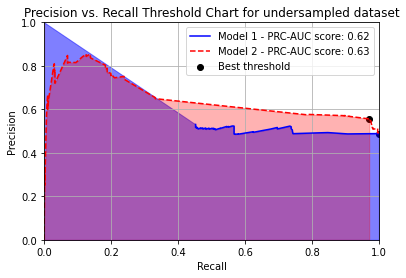

In [42]:
best_threshold1, best_threshold2 = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "undersampled dataset")

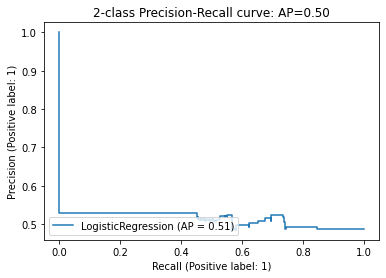

In [43]:
simple_threshold_plot(lr_model1, x1_test, y_test)

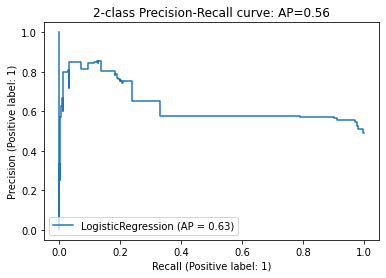

In [44]:
simple_threshold_plot(lr_model2, x2_test, y_test)

In [45]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[19][0] = "Undersampled_Logistic_Regression_Best_Threshold"
results_data[19][1] = lr_model1.score(x1_test, y_test)
results_data[19][2] = lr_model2.score(x2_test, y_test)
results_data[19][3] = acc1
results_data[19][4] = acc2
results_data[19][5] = prc_val1
results_data[19][6] = prc_val2
results_data[19][7] = pr_auc1
results_data[19][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.529028642168441
Average Precision-Recall Score: 0.5143381857782776
PRC-AUC for model 1: 0.6194772985424065
Accuracy: 0.489
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       583
           1       0.49      1.00      0.66       557

    accuracy                           0.49      1140
   macro avg       0.24      0.50      0.33      1140
weighted avg       0.24      0.49      0.32      1140


Scores for model 2
------------------
Roc_Auc Score: 0.6733219187573716
Average Precision-Recall Score: 0.6319277424758989
PRC-AUC for model 2: 0.6337368170329749
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.26      0.40       583
           1       0.56      0.97      0.71       557

    accuracy                           0.61      1140
   macro avg       0.73      0.62      0.55      1140
weighted a

##### Cross Validation After Undersampling Rebalance for model 1

###### Repeated KFold

In [46]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, usx1, usy)
results_data[20][0] = "Undersampled_Logistic_Regression_rkf"
results_data[20][1] = model_score
results_data[20][3] = acc
results_data[20][5] = prc_val
results_data[20][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, usx1, usy, best_threshold1)
results_data[21][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
results_data[21][1] = model_score
results_data[21][3] = acc
results_data[21][5] = prc_val
results_data[21][7] = pr_auc

Rkf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model1, usx1, usy)
results_data[22][0] = "Undersampled_Random_Forrest_rkf"
results_data[22][1] = model_score
results_data[22][3] = acc
results_data[22][5] = prc_val
results_data[22][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model1, usx1, usy)
results_data[23][0] = "Undersampled_XGB_Classifier_rkf"
results_data[23][1] = model_score
results_data[23][3] = acc
results_data[23][5] = prc_val
results_data[23][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  30   45   46   57   61   66   74   99  100  104  111  114  129  139
  158  171  175  180  199  215  237  247  254  269  275  277  282  296
  306  312  319  357  361  370  372  385  396  411  429  438  449  455
  460  473  485  490  505  514  519  535  540  541  546  548  555  556
  578  579  596  601  602  604  613  615  618  627  628  631  661  664
  670  675  677  682  719  726  748  753  754  767  784  787  804  808
  810  811  812  825  847  873  885  886  891  904  911  913  920  926
  928  977  981 1000 1013 1025 1035 1044 1051 1052 1055 1062 1065 1081
 1092 1096 1098 1105 1122 1126 1129 1132 1135 1146 1148 1152 1221 1235
 1239 1240 1244 1266 1272 1293 1294 1308 1322 1353 1354 1356 1365 1377
 1379 1391 1395 1411 1414 1416 1417 1430 1448 1452 1456 1464 1468 1471
 1477 1481 1487 1505 1507 1515 1521 1537 1538 1

In [47]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, usx1, usy)
results_data[24][0] = "Undersampled_Logistic_Regression_skf"
results_data[24][1] = model_score
results_data[24][3] = acc
results_data[24][5] = prc_val
results_data[24][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, usx1, usy, best_threshold1)
results_data[25][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
results_data[25][1] = model_score
results_data[25][3] = acc
results_data[25][5] = prc_val
results_data[25][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model1, usx1, usy)
results_data[26][0] = "Undersampled_Random_Forrest_skf"
results_data[26][1] = model_score
results_data[26][3] = acc
results_data[26][5] = prc_val
results_data[26][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model1, usx1, usy)
results_data[27][0] = "Undersampled_XGB_Classifier_skf"
results_data[27][1] = model_score
results_data[27][3] = acc
results_data[27][5] = prc_val
results_data[27][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [379 380 381 382 383 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433
 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523
 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 

In [48]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, usx1, usy)
results_data[28][0] = "Undersampled_Logistic_Regression_tss"
results_data[28][1] = model_score
results_data[28][3] = acc
results_data[28][5] = prc_val
results_data[28][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, usx1, usy, best_threshold1)
results_data[29][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
results_data[29][1] = model_score
results_data[29][3] = acc
results_data[29][5] = prc_val
results_data[29][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(rf_model1, usx1, usy)
results_data[30][0] = "Undersampled_Random_Forrest_tss"
results_data[30][1] = model_score
results_data[30][3] = acc
results_data[30][5] = prc_val
results_data[30][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model1, usx1, usy)
results_data[31][0] = "Undersampled_XGB_Classifier_tss"
results_data[31][1] = model_score
results_data[31][3] = acc
results_data[31][5] = prc_val
results_data[31][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 

 1265 1266 1267]

Model Score: 0.49921011058451814

Average Precision-Recall Score: 0.5479776323378219
PRC-AUC Score: 0.700931191100892
Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.96      0.64       297
           1       0.71      0.10      0.17       336

    accuracy                           0.50       633
   macro avg       0.60      0.53      0.40       633
weighted avg       0.60      0.50      0.39       633

Accuracy: 0.499
Mean Average-Precision Recall Score: 0.49685201030123416
--------------------------------------
|Scores for Random Forrest Classifier|
--------------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  

##### Cross Validation After Undersampling Rebalance for model 2

In [49]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, usx2, usy)
results_data[20][2] = model_score
results_data[20][4] = acc
results_data[20][6] = prc_val
results_data[20][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, usx2, usy, best_threshold2)
results_data[21][2] = model_score
results_data[21][4] = acc
results_data[21][6] = prc_val
results_data[21][8] = pr_auc

Rkf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model2, usx2, usy)
results_data[22][2] = model_score
results_data[22][4] = acc
results_data[22][6] = prc_val
results_data[22][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model2, usx2, usy)
results_data[23][2] = model_score
results_data[23][4] = acc
results_data[23][6] = prc_val
results_data[23][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  30   45   46   57   61   66   74   99  100  104  111  114  129  139
  158  171  175  180  199  215  237  247  254  269  275  277  282  296
  306  312  319  357  361  370  372  385  396  411  429  438  449  455
  460  473  485  490  505  514  519  535  540  541  546  548  555  556
  578  579  596  601  602  604  613  615  618  627  628  631  661  664
  670  675  677  682  719  726  748  753  754  767  784  787  804  808
  810  811  812  825  847  873  885  886  891  904  911  913  920  926
  928  977  981 1000 1013 1025 1035 1044 1051 1052 1055 1062 1065 1081
 1092 1096 1098 1105 1122 1126 1129 1132 1135 1146 1148 1152 1221 1235
 1239 1240 1244 1266 1272 1293 1294 1308 1322 1353 1354 1356 1365 1377
 1379 1391 1395 1411 1414 1416 1417 1430 1448 1452 1456 1464 1468 1471
 1477 1481 1487 1505 1507 1515 1521 1537 1538 1

In [50]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, usx2, usy)
results_data[24][2] = model_score
results_data[24][4] = acc
results_data[24][6] = prc_val
results_data[24][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, usx2, usy, best_threshold2)
results_data[25][2] = model_score
results_data[25][4] = acc
results_data[25][6] = prc_val
results_data[25][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model2, usx2, usy)
results_data[26][2] = model_score
results_data[26][4] = acc
results_data[26][6] = prc_val
results_data[26][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model2, usx2, usy)
results_data[27][2] = model_score
results_data[27][4] = acc
results_data[27][6] = prc_val
results_data[27][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1122 1125 1128 1131 1133 1134 1136 1137 1138 1139 1140 1141 1142 1144
 1145 1147 1149 1151 1152 1154 1155 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209
 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237
 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251
 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265
 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279
 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293
 1294 1295 1296 1297 1298 1299 1300 1301 1302 1

In [51]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, usx2, usy)
results_data[28][2] = model_score
results_data[28][4] = acc
results_data[28][6] = prc_val
results_data[28][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, usx2, usy, best_threshold2)
results_data[29][2] = model_score
results_data[29][4] = acc
results_data[29][6] = prc_val
results_data[29][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(rf_model2, usx2, usy)
results_data[30][2] = model_score
results_data[30][4] = acc
results_data[30][6] = prc_val
results_data[30][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model2, usx2, usy)
results_data[31][2] = model_score
results_data[31][4] = acc
results_data[31][6] = prc_val
results_data[31][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 

Mean Average-Precision Recall Score: 0.5289309401018569
--------------------------------------
|Scores for Random Forrest Classifier|
--------------------------------------
With normal threshold
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196

#### Oversampling

In [52]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [53]:
# For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

print("x1 Before SMOTE:")

print(x1_train.shape)

print("x2 Before SMOTE:")

print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")

print(oversampled_X1.shape)

print("x2 After SMOTE:")

print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(2660, 5)
x2 Before SMOTE:
(2660, 129)
x1 After SMOTE:
(80286, 5)
x2 After SMOTE:
(80286, 129)

Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: Bug, dtype: float64


In [54]:
x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[32][0] = "Oversampled_Logistic_Regression"
results_data[32][1] = lr_model1.score(x1_test, y1_test)
results_data[32][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[33][0] = "Oversampled_Random_Forrest"
results_data[33][1] = rf_model1.score(x1_test, y1_test)
results_data[33][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[34][0] = "Oversampled_XGB_Classifier"
results_data[34][1] = xgb_model1.score(x1_test, y1_test)
results_data[34][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5221705555094246
Logistic regression training score for model 2: 0.642821556090675
Random Forrest Classification training score for model 1: 0.6629162168894793
Random Forrest Classification training score for model 2: 0.6649505937058873
XGB Classifier training score for model 1: 0.6630407705721166
XGB Classifier training score for model 2: 0.6649090758116748


In [55]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[32][3] = acc1
results_data[32][4] = acc2
results_data[32][5] = prc_val1
results_data[32][6] = prc_val2
results_data[32][7] = pr_auc1
results_data[32][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[33][3] = acc1
results_data[33][4] = acc2
results_data[33][5] = prc_val1
results_data[33][6] = prc_val2
results_data[33][7] = pr_auc1
results_data[33][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[34][3] = acc1
results_data[34][4] = acc2
results_data[34][5] = prc_val1
results_data[34][6] = prc_val2
results_data[34][7] = pr_auc1
results_data[34][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5216188355262912
Average Precision-Recall Score: 0.5154592998412464
PRC-AUC for model 1: 0.6203659183993577
Accuracy: 0.522
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.54      0.53     12112
           1       0.52      0.51      0.51     11974

    accuracy                           0.52     24086
   macro avg       0.52      0.52      0.52     24086
weighted avg       0.52      0.52      0.52     24086


Scores for model 2
------------------
Roc_Auc Score: 0.7222612576864581
Average Precision-Recall Score: 0.6848891140588935
PRC-AUC for model 2: 0.71565556149251
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.45      0.56     12112
           1       0.60      0.84      0.70     11974

    accuracy        

In [56]:
y1_test.value_counts()

0    12112
1    11974
Name: Bug, dtype: int64

###### Compare Precision-Recall thresholds between models for oversampling

Best Threshold=0.474768, F1-Score=0.664 for model 1
Best Threshold=0.363335, F1-Score=0.719 for model 2


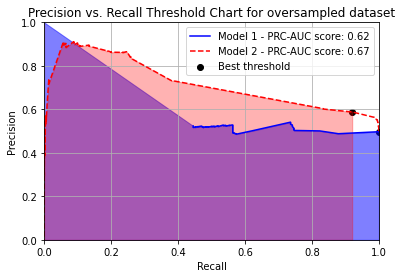

In [57]:
best_threshold1, best_threshold2 = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "oversampled dataset")

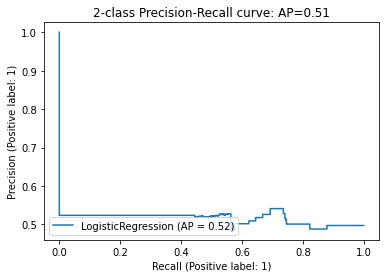

In [58]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

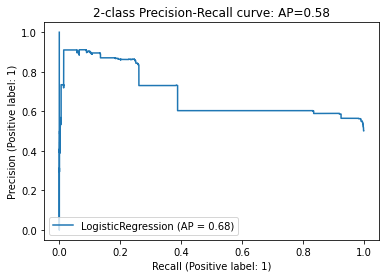

In [59]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using best threshold...

In [60]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[35][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[35][1] = lr_model1.score(x1_test, y1_test)
results_data[35][2] = lr_model2.score(x2_test, y2_test)
results_data[35][3] = acc1
results_data[35][4] = acc2
results_data[35][5] = prc_val1
results_data[35][6] = prc_val2
results_data[35][7] = pr_auc1
results_data[35][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5216188355262912
Average Precision-Recall Score: 0.5154592998412464
PRC-AUC for model 1: 0.6203659183993577
Accuracy: 0.497
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12112
           1       0.50      1.00      0.66     11974

    accuracy                           0.50     24086
   macro avg       0.25      0.50      0.33     24086
weighted avg       0.25      0.50      0.33     24086


Scores for model 2
------------------
Roc_Auc Score: 0.7222612576864581
Average Precision-Recall Score: 0.6848891140588935
PRC-AUC for model 2: 0.67020345103491
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.37      0.51     12112
           1       0.59      0.92      0.72     11974

    accuracy                           0.64     24086
   macro avg       0.71      0.64      0.61     24086
weighted av

##### Cross Validation After Oversampling Rebalance for model 1

In [61]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, osx1, osy1)
results_data[36][0] = "Oversampled_Logistic_Regression_rkf"
results_data[36][1] = model_score
results_data[36][3] = acc
results_data[36][5] = prc_val
results_data[36][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, osx1, osy1, best_threshold1)
results_data[37][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
results_data[37][1] = model_score
results_data[37][3] = acc
results_data[37][5] = prc_val
results_data[37][7] = pr_auc

Rkf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model1, osx1, osy1)
results_data[38][0] = "Oversampled_Random_Forrest_rkf"
results_data[38][1] = model_score
results_data[38][3] = acc
results_data[38][5] = prc_val
results_data[38][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model1, osx1, osy1)
results_data[39][0] = "Oversampled_XGB_Classifier_rkf"
results_data[39][1] = model_score
results_data[39][3] = acc
results_data[39][5] = prc_val
results_data[39][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 80282 80283 80285] | TEST: [    6    11    12 ... 80265 80273 80284]

Model Score: 0.5239755884917175
Average Precision-Recall Score: 0.5212862306792292
PRC-AUC Score: 0.6289286617896315
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.54      0.53      3946
           1       0.53      0.50      0.52      4083

    accuracy                           0.52      8029
   macro avg       0.52      0.52      0.52      8029
weighted avg       0.52      0.52      0.52      8029

Accuracy: 0.524
---------------------
With best threshold
TRAIN: [    0     1     2 ... 80282 80283 80285] | TEST: [    6    11    12 ... 80265 80273 80284]

Model Score: 0.5239755884917175
Average Precision-Recall Score: 0.5031480989261411
PRC-AUC Score: 0.7225709057864348
Classification Report:

            

In [62]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, osx1, osy1)
results_data[40][0] = "Oversampled_Logistic_Regression_skf"
results_data[40][1] = model_score
results_data[40][3] = acc
results_data[40][5] = prc_val
results_data[40][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, osx1, osy1, best_threshold1)
results_data[41][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
results_data[41][1] = model_score
results_data[41][3] = acc
results_data[41][5] = prc_val
results_data[41][7] = pr_auc

Skf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model1, osx1, osy1)
results_data[42][0] = "Oversampled_Random_Forrest_skf"
results_data[42][1] = model_score
results_data[42][3] = acc
results_data[42][5] = prc_val
results_data[42][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model1, osx1, osy1)
results_data[43][0] = "Oversampled_XGB_Classifier_skf"
results_data[43][1] = model_score
results_data[43][3] = acc
results_data[43][5] = prc_val
results_data[43][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 80283 80284 80285] | TEST: [ 8144  8145  8146 ... 52182 52183 52184]

Model Score: 0.5994519865487608

Average Precision-Recall Score: 0.5786055420825836
PRC-AUC Score: 0.7164642028457248
Classification Report:

              precision    recall  f1-score   support

           0       0.56      0.93      0.70      4015
           1       0.79      0.27      0.40      4014

    accuracy                           0.60      8029
   macro avg       0.68      0.60      0.55      8029
weighted avg       0.68      0.60      0.55      8029

Accuracy: 0.599
---------------------
With best threshold
TRAIN: [    0     1     2 ... 80283 80284 80285] | TEST: [ 8144  8145  8146 ... 52182 52183 52184]

Model Score: 0.5994519865487608

Average Precision-Recall Score: 0.5786055420825836
PRC-AUC Score: 0.7146684449623315
Classification Report:

          

In [63]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, osx1, osy1)
results_data[44][0] = "Oversampled_Logistic_Regression_tss"
results_data[44][1] = model_score
results_data[44][3] = acc
results_data[44][5] = prc_val
results_data[44][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, osx1, osy1, best_threshold1)
results_data[45][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
results_data[45][1] = model_score
results_data[45][3] = acc
results_data[45][5] = prc_val
results_data[45][7] = pr_auc

Tss_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(rf_model1, osx1, osy1)
results_data[46][0] = "Oversampled_Random_Forrest_tss"
results_data[46][1] = model_score
results_data[46][3] = acc
results_data[46][5] = prc_val
results_data[46][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model1, osx1, osy1)
results_data[47][0] = "Oversampled_XGB_Classifier_tss"
results_data[47][1] = model_score
results_data[47][3] = acc
results_data[47][5] = prc_val
results_data[47][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.055377027128017335

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.06      0.10     13381

    accuracy                           0.06     13381
   macro avg       0.50      0.03      0.05     13381
weighted avg       1.00      0.06      0.10     13381

Accuracy: 0.055
---------------------
With best threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.055377027128017335

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           

##### Cross Validation After Oversampling Rebalance for model 2

In [64]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, osx2, osy2)
results_data[36][2] = model_score
results_data[36][4] = acc
results_data[36][6] = prc_val
results_data[36][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, osx2, osy2, best_threshold2)
results_data[37][2] = model_score
results_data[37][4] = acc
results_data[37][6] = prc_val
results_data[37][8] = pr_auc

Rkf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model2, osx2, osy2)
results_data[38][2] = model_score
results_data[38][4] = acc
results_data[38][6] = prc_val
results_data[38][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model2, osx2, osy2)
results_data[39][2] = model_score
results_data[39][4] = acc
results_data[39][6] = prc_val
results_data[39][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 80282 80284 80285] | TEST: [   30    35    38 ... 80275 80281 80283]

Model Score: 0.651096163428002
Average Precision-Recall Score: 0.5948199029913254
PRC-AUC Score: 0.7238624229854183
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.46      0.57      3982
           1       0.61      0.84      0.71      4046

    accuracy                           0.65      8028
   macro avg       0.68      0.65      0.64      8028
weighted avg       0.67      0.65      0.64      8028

Accuracy: 0.651
---------------------
With best threshold
TRAIN: [    0     1     2 ... 80282 80283 80285] | TEST: [    6    11    12 ... 80265 80273 80284]

Model Score: 0.644040353717773
Average Precision-Recall Score: 0.5920254016279353
PRC-AUC Score: 0.7795822005529883
Classification Report:

              

In [65]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, osx2, osy2)
results_data[40][2] = model_score
results_data[40][4] = acc
results_data[40][6] = prc_val
results_data[40][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, osx2, osy2, best_threshold2)
results_data[41][2] = model_score
results_data[41][4] = acc
results_data[41][6] = prc_val
results_data[41][8] = pr_auc

Skf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model2, osx2, osy2)
results_data[42][2] = model_score
results_data[42][4] = acc
results_data[42][6] = prc_val
results_data[42][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model1, osx1, osy1)
results_data[43][2] = model_score
results_data[43][4] = acc
results_data[43][6] = prc_val
results_data[43][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [ 4015  4016  4017 ... 80283 80284 80285] | TEST: [    0     1     2 ... 44154 44155 44156]

Model Score: 0.6936106613525969

Average Precision-Recall Score: 0.6935343311735616
PRC-AUC Score: 0.9164512906257118
Classification Report:

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      4015
           1       1.00      0.39      0.56      4014

    accuracy                           0.69      8029
   macro avg       0.81      0.69      0.66      8029
weighted avg       0.81      0.69      0.66      8029

Accuracy: 0.694
---------------------
With best threshold
TRAIN: [ 4015  4016  4017 ... 80283 80284 80285] | TEST: [    0     1     2 ... 44154 44155 44156]

Model Score: 0.6936106613525969

Average Precision-Recall Score: 0.6935343311735616
PRC-AUC Score: 0.7416224573136713
Classification Report:

          

In [66]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, osx2, osy2)
results_data[44][2] = model_score
results_data[44][4] = acc
results_data[44][6] = prc_val
results_data[44][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, osx2, osy2, best_threshold2)
results_data[45][2] = model_score
results_data[45][4] = acc
results_data[45][6] = prc_val
results_data[45][8] = pr_auc

Tss_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(rf_model2, osx2, osy2)
results_data[46][2] = model_score
results_data[46][4] = acc
results_data[46][6] = prc_val
results_data[46][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model2, osx2, osy2)
results_data[47][2] = model_score
results_data[47][4] = acc
results_data[47][6] = prc_val
results_data[47][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.1854121515581795

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.19      0.31     13381

    accuracy                           0.19     13381
   macro avg       0.50      0.09      0.16     13381
weighted avg       1.00      0.19      0.31     13381

Accuracy: 0.185
---------------------
With best threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.1854121515581795

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0   

##### Combining Oversampling with Undersampling

In [67]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [68]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
print("x1 Before SMOTE:")
print(x1.shape)
print("x2 Before SMOTE:")
print(x2.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")
print(oversampled_X1.shape)
print("x2 After SMOTE:")
print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(42090, 5)
x2 Before SMOTE:
(42090, 129)
x1 After SMOTE:
(80286, 5)
x2 After SMOTE:
(80286, 129)

Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: Bug, dtype: float64


In [69]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

print("x1 Before RandomUnderSampler:")
print(osx1.shape)
print("x2 Before RandomUnderSampler:")
print(osx2.shape)

balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

print("x1 After RandomUnderSampler:")
print(balanced_x1.shape)
print("x2 After RandomUnderSampler:")
print(balanced_x1.shape)

print('\nBalance of positive and negative classes (%):')
print(balanced_y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(balanced_y2.value_counts(normalize=True) * 100)

x1 Before RandomUnderSampler:
(80286, 5)
x2 Before RandomUnderSampler:
(80286, 129)
x1 After RandomUnderSampler:
(80286, 5)
x2 After RandomUnderSampler:
(80286, 5)

Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: Bug, dtype: float64


In [70]:
x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[48][0] = "OSUS_Combination_Logistic_Regression"
results_data[48][1] = lr_model1.score(x1_test, y1_test)
results_data[48][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[49][0] = "OSUS_Combination_Random_Forrest"
results_data[49][1] = rf_model1.score(x1_test, y1_test)
results_data[49][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[50][0] = "OSUS_Combination_XGB_Classifier"
results_data[50][1] = xgb_model1.score(x1_test, y1_test)
results_data[50][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5235821639126463
Logistic regression training score for model 2: 0.6455202192144814
Random Forrest Classification training score for model 1: 0.6622519305820809
Random Forrest Classification training score for model 2: 0.6637050568795151
XGB Classifier training score for model 1: 0.6625840737357801
XGB Classifier training score for model 2: 0.6635389853026654


In [71]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[48][3] = acc1
results_data[48][4] = acc2
results_data[48][5] = prc_val1
results_data[48][6] = prc_val2
results_data[48][7] = pr_auc1
results_data[48][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[49][3] = acc1
results_data[49][4] = acc2
results_data[49][5] = prc_val1
results_data[49][6] = prc_val2
results_data[49][7] = pr_auc1
results_data[49][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[50][3] = acc1
results_data[50][4] = acc2
results_data[50][5] = prc_val1
results_data[50][6] = prc_val2
results_data[50][7] = pr_auc1
results_data[50][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5235230461448306
Average Precision-Recall Score: 0.5158633868225815
PRC-AUC for model 1: 0.6209398024730114
Accuracy: 0.524
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.53      0.53     12105
           1       0.52      0.51      0.52     11981

    accuracy                           0.52     24086
   macro avg       0.52      0.52      0.52     24086
weighted avg       0.52      0.52      0.52     24086


Scores for model 2
------------------
Roc_Auc Score: 0.7231508990156899
Average Precision-Recall Score: 0.6858190195181872
PRC-AUC for model 2: 0.7163299317642216
Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.46      0.56     12105
           1       0.60      0.84      0.70     11981

    accuracy      

###### Compare Precision-Recall thresholds between models for oversampling and undersampling combination

Best Threshold=0.477737, F1-Score=0.664 for model 1
Best Threshold=0.361405, F1-Score=0.718 for model 2


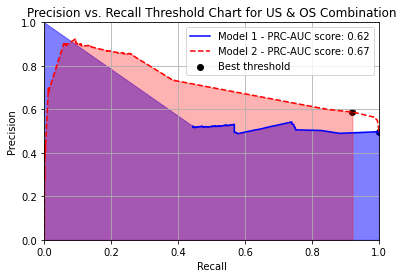

In [72]:
best_threshold1, best_threshold2 = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "US & OS Combination")

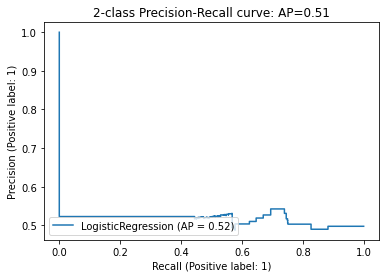

In [73]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

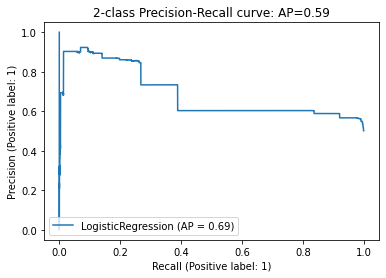

In [74]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using the best threshold...

In [75]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[51][0] = "OSUS_Logistic_Regression_Best_Threshold"
results_data[51][1] = lr_model1.score(x1_test, y1_test)
results_data[51][2] = lr_model2.score(x2_test, y2_test)
results_data[51][3] = acc1
results_data[51][4] = acc2
results_data[51][5] = prc_val1
results_data[51][6] = prc_val2
results_data[51][7] = pr_auc1
results_data[51][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5235230461448306
Average Precision-Recall Score: 0.5158633868225815
PRC-AUC for model 1: 0.6209398024730114
Accuracy: 0.497
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12105
           1       0.50      1.00      0.66     11981

    accuracy                           0.50     24086
   macro avg       0.25      0.50      0.33     24086
weighted avg       0.25      0.50      0.33     24086


Scores for model 2
------------------
Roc_Auc Score: 0.7231508990156899
Average Precision-Recall Score: 0.6858190195181872
PRC-AUC for model 2: 0.6713369331273945
Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.36      0.50     12105
           1       0.59      0.92      0.72     11981

    accuracy                           0.64     24086
   macro avg       0.71      0.64      0.61     24086
weighted 

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 1

In [76]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, balanced_x1, balanced_y1)
results_data[52][0] = "OSUS_Combination_Logistic_Regression_rkf"
results_data[52][1] = model_score
results_data[52][3] = acc
results_data[52][5] = prc_val
results_data[52][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model1, balanced_x1, balanced_y1, best_threshold1)
results_data[53][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
results_data[53][1] = model_score
results_data[53][3] = acc
results_data[53][5] = prc_val
results_data[53][7] = pr_auc

Rkf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model1, balanced_x1, balanced_y1)
results_data[54][0] = "OSUS_Combination_Random_Forrest_rkf"
results_data[54][1] = model_score
results_data[54][3] = acc
results_data[54][5] = prc_val
results_data[54][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model1, balanced_x1, balanced_y1)
results_data[55][0] = "OSUS_Combination_XGB_Classifier_rkf"
results_data[55][1] = model_score
results_data[55][3] = acc
results_data[55][5] = prc_val
results_data[55][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 80282 80283 80285] | TEST: [    6    11    12 ... 80265 80273 80284]

Model Score: 0.5241001370033628
Average Precision-Recall Score: 0.5199370331264076
PRC-AUC Score: 0.6322413824196094
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.54      0.53      3957
           1       0.53      0.51      0.52      4072

    accuracy                           0.52      8029
   macro avg       0.52      0.52      0.52      8029
weighted avg       0.52      0.52      0.52      8029

Accuracy: 0.524
---------------------
With best threshold
TRAIN: [    0     1     2 ... 80283 80284 80285] | TEST: [   21    33    34 ... 80269 80271 80273]

Model Score: 0.5255947191431063
Average Precision-Recall Score: 0.5015124212217799
PRC-AUC Score: 0.7228003480183438
Classification Report:

            

In [77]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, balanced_x1, balanced_y1)
results_data[56][0] = "OSUS_Combination_Logistic_Regression_skf"
results_data[56][1] = model_score
results_data[56][3] = acc
results_data[56][5] = prc_val
results_data[56][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model1, balanced_x1, balanced_y1, best_threshold1)
results_data[57][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
results_data[57][1] = model_score
results_data[57][3] = acc
results_data[57][5] = prc_val
results_data[57][7] = pr_auc

Skf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[58][0] = "OSUS_Combination_Random_Forrest_skf"
results_data[58][1] = model_score
results_data[58][3] = acc
results_data[58][5] = prc_val
results_data[58][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model1, balanced_x1, balanced_y1)
results_data[59][0] = "OSUS_Combination_XGB_Classifier_skf"
results_data[59][1] = model_score
results_data[59][3] = acc
results_data[59][5] = prc_val
results_data[59][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 80283 80284 80285] | TEST: [ 8030  8031  8032 ... 52182 52183 52184]

Model Score: 0.5782787395690622

Average Precision-Recall Score: 0.5624127491210998
PRC-AUC Score: 0.789871328749697
Classification Report:

              precision    recall  f1-score   support

           0       0.55      0.95      0.69      4015
           1       0.80      0.21      0.33      4014

    accuracy                           0.58      8029
   macro avg       0.67      0.58      0.51      8029
weighted avg       0.67      0.58      0.51      8029

Accuracy: 0.578
---------------------
With best threshold
TRAIN: [    0     1     2 ... 80283 80284 80285] | TEST: [ 8030  8031  8032 ... 52182 52183 52184]

Model Score: 0.5782787395690622

Average Precision-Recall Score: 0.5624127491210998
PRC-AUC Score: 0.6987598870930304
Classification Report:

           

In [78]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, balanced_x1, balanced_y1)
results_data[60][0] = "OSUS_Combination_Logistic_Regression_tss"
results_data[60][1] = model_score
results_data[60][3] = acc
results_data[60][5] = prc_val
results_data[60][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model1, balanced_x1, balanced_y1, best_threshold1)
results_data[61][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
results_data[61][1] = model_score
results_data[61][3] = acc
results_data[61][5] = prc_val
results_data[61][7] = pr_auc

Tss_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[62][0] = "OSUS_Combination_Random_Forrest_tss"
results_data[62][1] = model_score
results_data[62][3] = acc
results_data[62][5] = prc_val
results_data[62][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model1, balanced_x1, balanced_y1)
results_data[63][0] = "OSUS_Combination_XGB_Classifier_tss"
results_data[63][1] = model_score
results_data[63][3] = acc
results_data[63][5] = prc_val
results_data[63][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.053882370525371794

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999998
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.05      0.10     13381

    accuracy                           0.05     13381
   macro avg       0.50      0.03      0.05     13381
weighted avg       1.00      0.05      0.10     13381

Accuracy: 0.054
---------------------
With best threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.053882370525371794

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   suppo

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 2

In [79]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, balanced_x2, balanced_y2)
results_data[52][2] = model_score
results_data[52][4] = acc
results_data[52][6] = prc_val
results_data[52][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Rkf(lr_model2, balanced_x2, balanced_y2, best_threshold2)
results_data[53][2] = model_score
results_data[53][4] = acc
results_data[53][6] = prc_val
results_data[53][8] = pr_auc

Rkf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(rf_model2, balanced_x2, balanced_y2)
results_data[54][2] = model_score
results_data[54][4] = acc
results_data[54][6] = prc_val
results_data[54][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Rkf(xgb_model2, balanced_x2, balanced_y2)
results_data[55][2] = model_score
results_data[55][4] = acc
results_data[55][6] = prc_val
results_data[55][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 80281 80282 80283] | TEST: [    4    13    16 ... 80265 80284 80285]

Model Score: 0.6510150703699091
Average Precision-Recall Score: 0.5960353290687117
PRC-AUC Score: 0.7334656539137002
Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.46      0.57      3968
           1       0.61      0.84      0.71      4061

    accuracy                           0.65      8029
   macro avg       0.67      0.65      0.64      8029
weighted avg       0.67      0.65      0.64      8029

Accuracy: 0.651
---------------------
With best threshold
TRAIN: [    0     1     2 ... 80282 80283 80285] | TEST: [    6    11    12 ... 80265 80273 80284]

Model Score: 0.6477768090671316
Average Precision-Recall Score: 0.5936201883341476
PRC-AUC Score: 0.7817567679822426
Classification Report:

            

In [80]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, balanced_x2, balanced_y2)
results_data[56][2] = model_score
results_data[56][4] = acc
results_data[56][6] = prc_val
results_data[56][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Skf(lr_model2, balanced_x2, balanced_y2, best_threshold2)
results_data[57][2] = model_score
results_data[57][4] = acc
results_data[57][6] = prc_val
results_data[57][8] = pr_auc

Skf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[58][2] = model_score
results_data[58][4] = acc
results_data[58][6] = prc_val
results_data[58][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(xgb_model2, balanced_x2, balanced_y2)
results_data[59][2] = model_score
results_data[59][4] = acc
results_data[59][6] = prc_val
results_data[59][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [ 4015  4016  4017 ... 80283 80284 80285] | TEST: [    0     1     2 ... 44154 44155 44156]

Model Score: 0.6992153443766347

Average Precision-Recall Score: 0.6991404104813623
PRC-AUC Score: 0.9292041594841063
Classification Report:

              precision    recall  f1-score   support

           0       0.62      1.00      0.77      4015
           1       1.00      0.40      0.57      4014

    accuracy                           0.70      8029
   macro avg       0.81      0.70      0.67      8029
weighted avg       0.81      0.70      0.67      8029

Accuracy: 0.699
---------------------
With best threshold
TRAIN: [ 4015  4016  4017 ... 80283 80284 80285] | TEST: [    0     1     2 ... 44154 44155 44156]

Model Score: 0.6992153443766347

Average Precision-Recall Score: 0.6991404104813623
PRC-AUC Score: 0.7400210379994885
Classification Report:

          

In [81]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, balanced_x2, balanced_y2)
results_data[60][2] = model_score
results_data[60][4] = acc
results_data[60][6] = prc_val
results_data[60][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, pr_auc = Tss(lr_model2, balanced_x2, balanced_y2, best_threshold2)
results_data[61][2] = model_score
results_data[61][4] = acc
results_data[61][6] = prc_val
results_data[61][8] = pr_auc

Tss_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[62][2] = model_score
results_data[62][4] = acc
results_data[62][6] = prc_val
results_data[62][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, pr_auc = Tss(xgb_model2, balanced_x2, balanced_y2)
results_data[63][2] = model_score
results_data[63][4] = acc
results_data[63][6] = prc_val
results_data[63][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.1955758164561692

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999998
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.20      0.33     13381

    accuracy                           0.20     13381
   macro avg       0.50      0.10      0.16     13381
weighted avg       1.00      0.20      0.33     13381

Accuracy: 0.196
---------------------
With best threshold
TRAIN: [    0     1     2 ... 53521 53522 53523] | TEST: [53524 53525 53526 ... 66902 66903 66904]

Model Score: 0.1955758164561692

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support



In [82]:
results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score'])
model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score']]
model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score']]

In [83]:
results_df

,Test,Model1 score,Model2 score,Model1 accuracy,Model2 accuracy,Model1 avg. PR score,Model2 avg. PR score,Model1 PRC-AUC Score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.912331,0.956047,0.912331,0.956047,0.050087,0.142122,0.047663,0.146788
1,Original_Random_Forrest,0.958818,0.959373,0.958818,0.959373,0.218823,0.224110,0.243844,0.245741
2,Original_XGB_Classifier,0.958739,0.959373,0.958739,0.959373,0.216289,0.225139,0.242915,0.253052
3,Original_Logistic_Regression_Best_Threshold,0.912331,0.956047,0.762176,0.940920,0.050087,0.142122,0.016463,0.068756
4,Original_Logistic_Regression_rkf,0.915419,0.957472,0.915419,0.957472,0.055210,0.099830,0.057356,0.179485
...,...,...,...,...,...,...,...,...,...
59,OSUS_Combination_XGB_Classifier_skf,0.705069,0.705567,0.705069,0.705567,0.704996,0.705494,0.960574,0.960492
60,OSUS_Combination_Logistic_Regression_tss,0.053882,0.195576,0.053882,0.195576,1.000000,1.000000,1.000000,1.000000
61,OSUS_Combination_Logistic_Regression_tss_Best_...,0.053882,0.195576,0.053882,0.195576,1.000000,1.000000,1.000000,1.000000
62,OSUS_Combination_Random_Forrest_tss,0.704695,0.705567,0.704695,0.705567,0.704622,0.705494,0.959816,0.956883


In [84]:
model1_results_df

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
0,Original_Logistic_Regression,0.912331,0.912331,0.050087,0.047663
1,Original_Random_Forrest,0.958818,0.958818,0.218823,0.243844
2,Original_XGB_Classifier,0.958739,0.958739,0.216289,0.242915
3,Original_Logistic_Regression_Best_Threshold,0.912331,0.762176,0.050087,0.016463
4,Original_Logistic_Regression_rkf,0.915419,0.915419,0.055210,0.057356
...,...,...,...,...,...
59,OSUS_Combination_XGB_Classifier_skf,0.705069,0.705069,0.704996,0.960574
60,OSUS_Combination_Logistic_Regression_tss,0.053882,0.053882,1.000000,1.000000
61,OSUS_Combination_Logistic_Regression_tss_Best_...,0.053882,0.053882,1.000000,1.000000
62,OSUS_Combination_Random_Forrest_tss,0.704695,0.704695,0.704622,0.959816


In [85]:
model2_results_df

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.956047,0.956047,0.142122,0.146788
1,Original_Random_Forrest,0.959373,0.959373,0.224110,0.245741
2,Original_XGB_Classifier,0.959373,0.959373,0.225139,0.253052
3,Original_Logistic_Regression_Best_Threshold,0.956047,0.940920,0.142122,0.068756
4,Original_Logistic_Regression_rkf,0.957472,0.957472,0.099830,0.179485
...,...,...,...,...,...
59,OSUS_Combination_XGB_Classifier_skf,0.705567,0.705567,0.705494,0.960492
60,OSUS_Combination_Logistic_Regression_tss,0.195576,0.195576,1.000000,1.000000
61,OSUS_Combination_Logistic_Regression_tss_Best_...,0.195576,0.195576,1.000000,1.000000
62,OSUS_Combination_Random_Forrest_tss,0.705567,0.705567,0.705494,0.956883


In [86]:
model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
59,OSUS_Combination_XGB_Classifier_skf,0.705069,0.705069,0.704996,0.960574
58,OSUS_Combination_Random_Forrest_skf,0.704695,0.704695,0.704622,0.959981
43,Oversampled_XGB_Classifier_skf,0.697845,0.697845,0.697770,0.957977
42,Oversampled_Random_Forrest_skf,0.696973,0.696973,0.696898,0.956012
56,OSUS_Combination_Logistic_Regression_skf,0.578279,0.578279,0.562413,0.789871
38,Oversampled_Random_Forrest_rkf,0.671400,0.671400,0.608180,0.787616
39,Oversampled_XGB_Classifier_rkf,0.671151,0.671151,0.607993,0.787043
55,OSUS_Combination_XGB_Classifier_rkf,0.669656,0.669656,0.610500,0.785893
54,OSUS_Combination_Random_Forrest_rkf,0.669532,0.669532,0.610432,0.785835
50,OSUS_Combination_XGB_Classifier,0.662584,0.662584,0.731828,0.775993


In [87]:
model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
59,OSUS_Combination_XGB_Classifier_skf,0.705567,0.705567,0.705494,0.960492
58,OSUS_Combination_Random_Forrest_skf,0.705567,0.705567,0.705494,0.959406
43,Oversampled_XGB_Classifier_skf,0.697845,0.697845,0.697770,0.957977
42,Oversampled_Random_Forrest_skf,0.699464,0.699464,0.699390,0.957059
56,OSUS_Combination_Logistic_Regression_skf,0.699215,0.699215,0.699140,0.929204
40,Oversampled_Logistic_Regression_skf,0.693611,0.693611,0.693534,0.916451
39,Oversampled_XGB_Classifier_rkf,0.672397,0.672397,0.608925,0.789483
38,Oversampled_Random_Forrest_rkf,0.672147,0.672147,0.608756,0.788841
55,OSUS_Combination_XGB_Classifier_rkf,0.671026,0.671026,0.611493,0.788559
54,OSUS_Combination_Random_Forrest_rkf,0.671151,0.671151,0.611601,0.788317
